# **Parkinson's Disease (PD) Wrist-Mounted Prediction Model**
<div class="alert-info">
    <p>Redback Operations: <strong>Lachesis
     </strong> </p>

## **Model Objective**

The goal of this project is to develop a machine learning model that leverages data from a wrist-mounted device to detect hand tremors—an early potential indicator of Parkinson's Disease (PD). Using data from a 3-axis accelerometer and gyroscope, the project evaluates various models to determine their effectiveness in classifying tremors.

## **Model Description**

6 different models have been built and will be evaluated below on the 'HandTremorDataset.csv' file. These models are:
- Logistic Regression
- Random Forest
- Decision Tree
- Support Vector Machine (SVM)
- Neural Network
- k-Nearest Neighbours (k-NN)

## **Model Implementation**

### **Intial Setup**

In [12]:
# Import supporting libraries

import pandas as pd
import time

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# The below libraries are used for model comparison
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# Load the dataset

# Load raw HandTremorDataset.csv from desired folder
# NOTE: This datatset has 9 features, the last three are not applicable to our model and will be ignored
dataset = pd.read_csv("HandTremorDataset.csv")

# Drop the readings from the 3-Axis Magnetometer
dataset = dataset.drop(columns=['mX', 'mY', 'mZ'])

print("HandTremorDataset.csv sample:\n")
print(dataset.head())

print("\naX, aY, aZ: Readings from the 3-Axis Accelerometer")
print("gX, gY, gZ: Readings from the 3-Axis Gyro")

HandTremorDataset.csv sample:

     aX     aY    aZ    gX    gY    gZ  Result
0 -2544  14340 -6864  3840  -335 -1518       1
1 -2380  14188 -5644  3888  1635 -9604       1
2  -524  14480 -7148  3888 -1663 -1491       1
3  -528  15052 -6672  3904   461 -4012       1
4 -2808  14040 -5936  3904   595  -339       1

aX, aY, aZ: Readings from the 3-Axis Accelerometer
gX, gY, gZ: Readings from the 3-Axis Gyro


In [14]:
# Analyse the dataset

# Validate integrity of the dataset
print("Dataset analysis:\n")
print(dataset.info())
print(dataset.describe())

# Check for missing values
print("\nMissing values:\n")
value_count = dataset.isnull().sum().sort_values()
value_percentage = (dataset.isnull().sum() / dataset.isnull().count() * 100).sort_values()
print(pd.concat([value_count, value_percentage], axis=1, keys=['Number of values', '% Grand Total']))

Dataset analysis:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27995 entries, 0 to 27994
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   aX      27995 non-null  int64
 1   aY      27995 non-null  int64
 2   aZ      27995 non-null  int64
 3   gX      27995 non-null  int64
 4   gY      27995 non-null  int64
 5   gZ      27995 non-null  int64
 6   Result  27995 non-null  int64
dtypes: int64(7)
memory usage: 1.5 MB
None
                 aX            aY            aZ            gX            gY  \
count  27995.000000  27995.000000  27995.000000  27995.000000  27995.000000   
mean      54.174960   5756.362779 -13338.659904   5002.228684   -239.641400   
std     5220.775301   5201.669402   3059.030305    485.190460    999.942236   
min    -9488.000000  -3148.000000 -19600.000000   3840.000000 -12023.000000   
25%    -5332.000000    776.000000 -16260.000000   4608.000000   -752.000000   
50%     1004.000000   4144.000000 -14248.

In [15]:

# Load data into variables with optimised synchronisation and vectorised preprocessing
def load_data():
    # Read data in chunks to manage memory
    chunk_size = 10000
    chunks = pd.read_csv("HandTremorDataset.csv", usecols=['aX','aY','aZ','gX','gY','gZ','Result'], chunksize=chunk_size)
    data = pd.concat(chunks, ignore_index=True)
    # Vectorised feature engineering: magnitude of accelerometer and gyroscope
    data['acc_mag'] = np.sqrt((data[['aX','aY','aZ']]**2).sum(axis=1))
    data['gyro_mag'] = np.sqrt((data[['gX','gY','gZ']]**2).sum(axis=1))
    # X contains 3D gyro and 3D accelerometer data
    X = data[['acc_mag','gyro_mag']]
    # y contains labels (0 for no tremor, 1 for tremor)
    y = data['Result']
    return X, y

X, y = load_data()  # Load and preprocess data


In [16]:
# Split the data into training and test sets

# Utilise a 70/30 split for Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("\nTrain/Test set sizes:\n")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


Train/Test set sizes:

X_train shape: (19596, 2)
X_test shape: (8399, 2)
y_train shape: (19596,)
y_test shape: (8399,)


In [17]:
# Standardise the data for models that benefit from standardisation

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### **Logistic Regression**

In [18]:
# Build the Logicstic Regression model

# Initialise the Logicstic Regression model
lr_model = LogisticRegression(random_state = 42, max_iter = 1000)

# Train the model
lr_model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [19]:
# Batch inference for scalability
batch_size = 5000  # Batch size for predictions
y_pred_lr = []

for start in range(0, len(X_test_scaled), batch_size):
    end = start + batch_size
    batch = X_test_scaled[start:end]
    y_pred_lr.extend(lr_model.predict(batch))  
# Scalable batch prediction for test set

# Evaluate the model's performance
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))


Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.74      0.69      3868
           1       0.75      0.66      0.70      4531

    accuracy                           0.70      8399
   macro avg       0.70      0.70      0.70      8399
weighted avg       0.70      0.70      0.70      8399

Confusion Matrix:
[[2851 1017]
 [1535 2996]]


### **Random Forest Classifier**

In [20]:
# Build the Random Forest Classifier model

# Initialise the Random Forest Classifier model
rf_model = RandomForestClassifier(random_state = 42)

# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [21]:

# Batch inference for scalability (Random Forest)
batch_size = 5000
y_pred_rf = []

for start in range(0, len(X_test), batch_size):
    end = start + batch_size
    batch = X_test[start:end]
    y_pred_rf.extend(rf_model.predict(batch))
# Scalable batch prediction for test set

# Evaluate the model's performance
# Print results
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.82      3868
           1       0.86      0.83      0.85      4531

    accuracy                           0.84      8399
   macro avg       0.83      0.84      0.84      8399
weighted avg       0.84      0.84      0.84      8399

Confusion Matrix:
[[3241  627]
 [ 752 3779]]


### **Decision Tree Classifier**

In [22]:
# Build the Decision Tree Classifier model

# Initialise the Decision Tree Classifier model
dt_model = DecisionTreeClassifier(random_state = 42)

# Train the model
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [23]:

# Batch inference for scalability (Decision Tree)
batch_size = 5000
y_pred_dt = []

for start in range(0, len(X_test), batch_size):
    end = start + batch_size
    batch = X_test[start:end]
    y_pred_dt.extend(dt_model.predict(batch))
# Scalable batch prediction for test set

# Evaluate the model's performance
# Print results
print("Classification Report:")
print(classification_report(y_test, y_pred_dt))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      3868
           1       0.82      0.81      0.82      4531

    accuracy                           0.80      8399
   macro avg       0.80      0.80      0.80      8399
weighted avg       0.81      0.80      0.80      8399

Confusion Matrix:
[[3079  789]
 [ 851 3680]]


### **Support Vector Machine (SVM)**

In [24]:
# Build the Support Vector Machine model

# Initialise the Support Vector Machine model
svm_model = SVC(kernel = 'rbf', random_state = 42)

# Train the model
svm_model.fit(X_train_scaled, y_train)

SVC(random_state=42)

In [25]:

# Batch inference for scalability
batch_size = 5000  # Batch size for predictions
y_pred_svm = []
for start in range(0, len(X_test_scaled), batch_size):
    end = start + batch_size
    batch = X_test_scaled[start:end]
    y_pred_svm.extend(svm_model.predict(batch))
# Scalable batch prediction for test set

# Evaluate the model's performance
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))


Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.77      0.75      3868
           1       0.79      0.76      0.78      4531

    accuracy                           0.76      8399
   macro avg       0.76      0.76      0.76      8399
weighted avg       0.77      0.76      0.76      8399

Confusion Matrix:
[[2983  885]
 [1100 3431]]


### **Neural Network**

In [26]:
# Build the Neural Network model

# Initialise the Neural Network model
mlp_model = MLPClassifier(hidden_layer_sizes = (100, 50), max_iter = 300, random_state = 42)

# Train the model
mlp_model.fit(X_train_scaled, y_train)

MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)

In [27]:

# Batch inference for scalability
batch_size = 5000  # Batch size for predictions
y_pred_mlp = []
for start in range(0, len(X_test_scaled), batch_size):
    end = start + batch_size
    batch = X_test_scaled[start:end]
    y_pred_mlp.extend(mlp_model.predict(batch))
# Scalable batch prediction for test set

# Evaluate the model's performance
print("Classification Report:")
print(classification_report(y_test, y_pred_mlp))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_mlp))


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.86      0.82      3868
           1       0.87      0.79      0.83      4531

    accuracy                           0.82      8399
   macro avg       0.83      0.83      0.82      8399
weighted avg       0.83      0.82      0.82      8399

Confusion Matrix:
[[3335  533]
 [ 941 3590]]


### **k-Nearest Neighbours (k-NN)**

In [28]:
# Build the k-Nearest Neighbours model

# Initialise the k-Nearest Neighbours model
knn_model = KNeighborsClassifier(n_neighbors = 5)

# Train the model
knn_model.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [29]:

# Batch inference for scalability
batch_size = 5000  # Batch size for predictions
y_pred_knn = []
for start in range(0, len(X_test_scaled), batch_size):
    end = start + batch_size
    batch = X_test_scaled[start:end]
    y_pred_knn.extend(knn_model.predict(batch))
# Scalable batch prediction for test set

# Evaluate the model's performance
print("Classification Report:")
print(classification_report(y_test, y_pred_knn))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.83      0.80      3868
           1       0.84      0.81      0.83      4531

    accuracy                           0.82      8399
   macro avg       0.81      0.82      0.82      8399
weighted avg       0.82      0.82      0.82      8399

Confusion Matrix:
[[3192  676]
 [ 872 3659]]


## **Model Comparison**

In [32]:
# Prepare data for visualisation

# Create dict of confusion matricies for each model
confusion_matricies = {
    "Logistic Regression": confusion_matrix(y_test, y_pred_lr),
    "Random Forest": confusion_matrix(y_test, y_pred_rf),
    "Decision Tree": confusion_matrix(y_test, y_pred_dt),
    "SVM": confusion_matrix(y_test, y_pred_svm),
    "Neural Network": confusion_matrix(y_test, y_pred_mlp),
    "k-NN": confusion_matrix(y_test, y_pred_knn),
}

# Create dict of predictions for each model
model_predictions = {
    "Logistic Regression": y_pred_lr,
    "Random Forest": y_pred_rf,
    "Decision Tree": y_pred_dt,
    "SVM": y_pred_svm,
    "Neural Network": y_pred_mlp,
    "k-NN": y_pred_knn,
}

# Initialise arrays to store various metrics
models = list(model_predictions.keys())
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Extract values from classification reports into arrays
for model_name, y_pred_all in model_predictions.items():
    report = classification_report(y_test, y_pred_all, output_dict = True)
    accuracies.append(report["accuracy"])
    precisions.append(report["1"]["precision"])
    recalls.append(report["1"]["recall"])
    f1_scores.append(report["1"]["f1-score"])

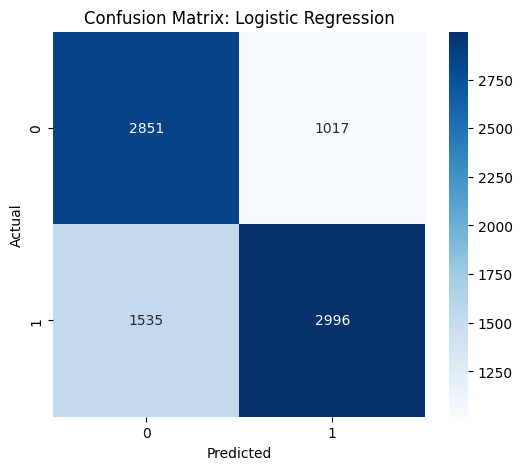

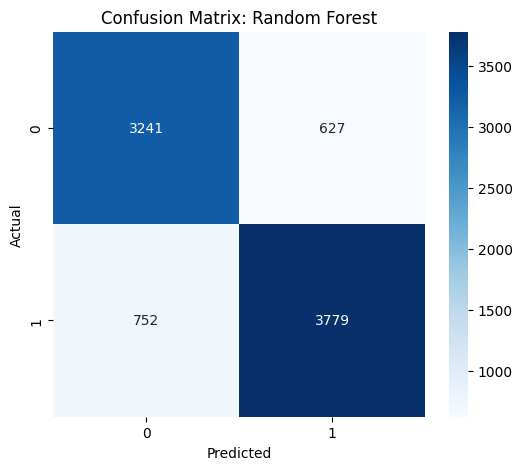

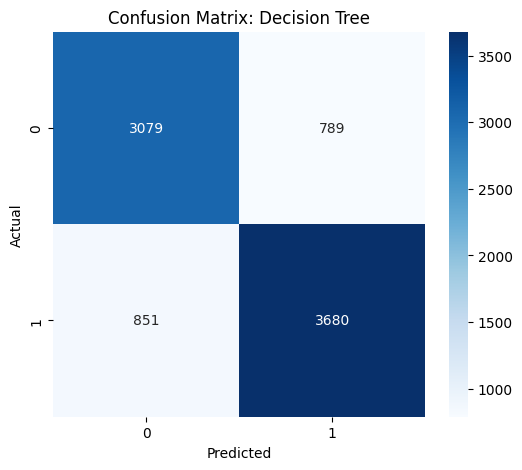

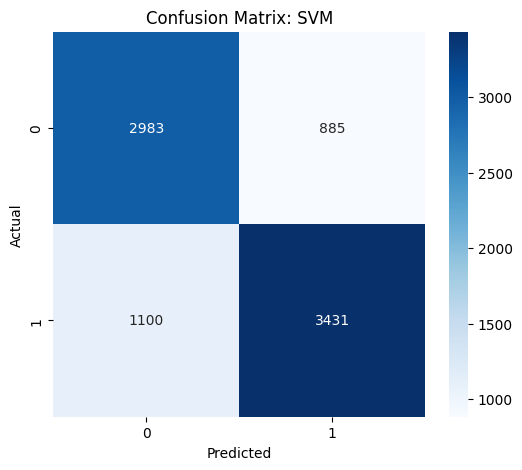

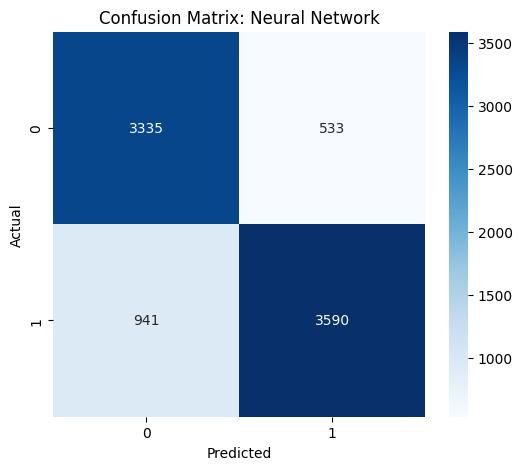

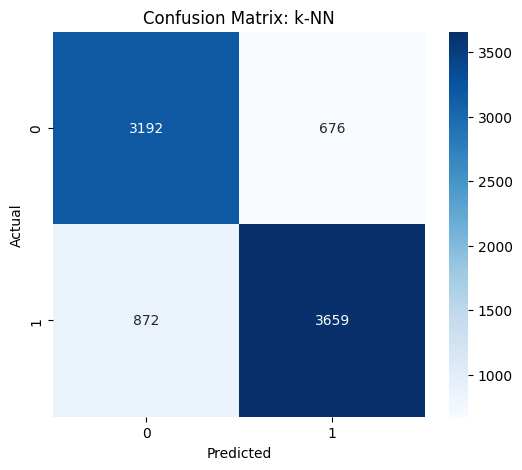

In [33]:
# Visualise confusion matrix of each model

# Plot confusion matricies for each model
for model, matrix in confusion_matricies.items():
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix: {model}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

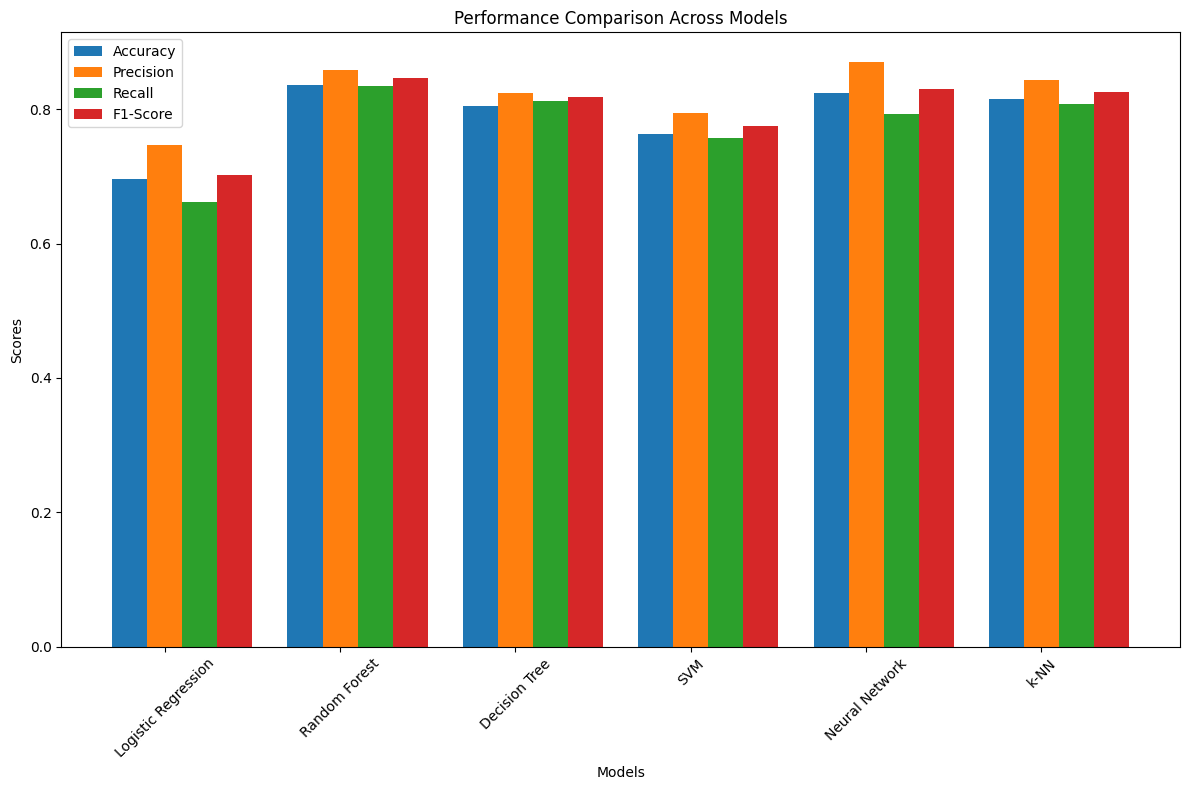

In [34]:
# Visualise metrics matrix of each model

# Plot metrics for evaluation
plt.figure(figsize = (12, 8))
x = np.arange(len(models))

plt.bar(x - 0.2, accuracies, width = 0.2, label = "Accuracy")
plt.bar(x, precisions, width = 0.2, label = "Precision")
plt.bar(x + 0.2, recalls, width = 0.2, label = "Recall")
plt.bar(x + 0.4, f1_scores, width = 0.2, label = "F1-Score")

plt.xticks(x, models, rotation = 45)
plt.xlabel("Models")
plt.ylabel("Scores")
plt.title("Performance Comparison Across Models")
plt.legend()
plt.tight_layout()
plt.show()